In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

In [ ]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

## 1. 간단한 전처리 및 데이터 분포 확인

### 1.1 데이터 차원 및 중복행 확인

In [ ]:
print(train.shape) #training set 약 10만행
print(test.shape) #test set 약 25000행

(103976, 13)
(25995, 12)


In [ ]:
train.head(3)

,country,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points
0,Australia,"Possibly a little sweet, this is a soft, easyg...",NaN,5.0,Australia Other,South Eastern Australia,NaN,Joe Czerwinski,@JoeCz,Banrock Station 2006 Chardonnay (South Eastern...,Chardonnay,Banrock Station,83
1,France,"A soft, almost off dry wine that is full in th...",Réserve,12.0,Rhône Valley,Côtes du Rhône,NaN,Roger Voss,@vossroger,Cellier des Dauphins 2015 Réserve Rosé (Côtes ...,Rosé,Cellier des Dauphins,85
2,Spain,Generic white-fruit aromas of peach and apple ...,Estate Grown & Bottled,9.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Esperanza 2013 Estate Grown & Bottled Verdejo-...,Verdejo-Viura,Esperanza,86


In [ ]:
train.columns

Index(['country', 'description', 'designation', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'points'],
      dtype='object')

In [ ]:
train.duplicated().sum() #모든 칼럼이 동일한 행이 약 6405행->의미가 없으므로 제거

6405

In [ ]:
#결측치 비율 확인
train.isnull().sum()/train.shape[0]*100

country                   0.049195
description               0.000000
designation              28.854885
price                     6.976458
province                  0.049195
region_1                 16.342971
region_2                 61.042728
taster_name              20.624981
taster_twitter_handle    24.433489
title                     0.000000
variety                   0.001025
winery                    0.000000
points                    0.000000
dtype: float64

* 약 61%로 높은 결측치 비율을 보이는 region_2 column은 제외하는 것이 타당해보인다
* designation, taster_name, taster_twitter_handle 등은 각 칼럼의 특성을 확인한 이후 삭제 혹은 모델 사용 여부를 결정하기로 한다

In [ ]:
#taster_name과 taster_twitter_handle 간 매칭 확인
train[(train['taster_name'].isna())&train['taster_twitter_handle'].notna()].shape

#taster_name은 결측치이지만, 트위터 아이디가 결측치가 아닌 경우는 존재하지 않음, 즉 최소한 taster_name이 기록된 항에만 트위터 아이디가 기재

(0, 12)

In [ ]:
train.drop("title", axis=1, inplace=True)
#train.drop("region_2", axis=1, inplace=True)

In [ ]:
train.groupby("taster_name")['taster_twitter_handle'].nunique()

taster_name
Alexander Peartree    0
Anna Lee C. Iijima    0
Anne Krebiehl MW      1
Carrie Dykes          0
Christina Pickard     1
Fiona Adams           1
Jeff Jenssen          1
Jim Gordon            1
Joe Czerwinski        1
Kerin O’Keefe         1
Lauren Buzzeo         1
Matt Kettmann         1
Michael Schachner     1
Mike DeSimone         1
Paul Gregutt          1
Roger Voss            1
Sean P. Sullivan      1
Susan Kostrzewa       1
Virginie Boone        1
Name: taster_twitter_handle, dtype: int64

* 모든 taster에 대해 고유한 트위터 아이디는 하나이므로 taster_twitter_handle은 삭제해도 무방

In [ ]:
train.drop('taster_twitter_handle', axis=1, inplace=True)

### 1.2 변수의 분포 확인

In [ ]:
#price 변수 분포
train['price'].describe()

count    90764.000000
mean        35.652021
std         43.356430
min          4.000000
25%         17.000000
50%         25.000000
75%         42.000000
max       3300.000000
Name: price, dtype: float64

* 최솟값이 3, 평균이 35, q3가 42이지만 max 값이 3300인점에서 이상치가 다수 존재한다는 점을 예측할 수 있다.

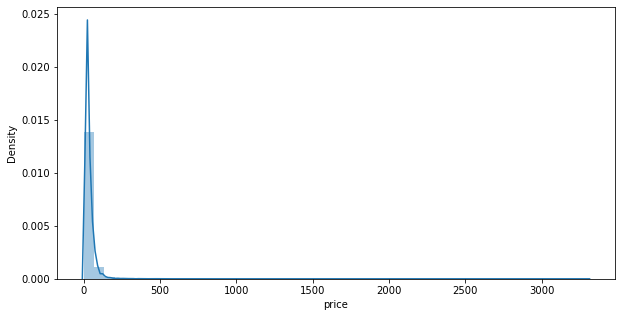

Skewness : 19.033
Kurtosis : 862.744


In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(train['price'])
plt.show()

print("Skewness : %.3f"%train['price'].skew())
print("Kurtosis : %.3f"%train['price'].kurtosis())

* price 변수의 distplot이 매우 왜곡되어 있고, 왜도 및 첨도도 정규분포의 가정을 위해 적합하지 않음을 알 수 있다.

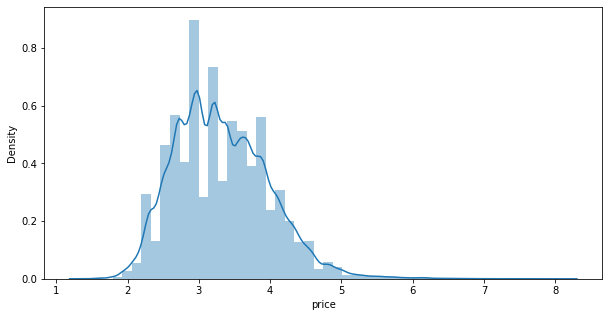

Skewness : 0.614
Kurtosis : 0.817


In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(train['price']))
plt.show()

print("Skewness : %.3f"%np.log(train['price']).skew())
print("Kurtosis : %.3f"%np.log(train['price']).kurtosis())

* 과하게 높은 와인의 가격을 이상치로 생각하기보다, 와인 산업의 특성상 높은 가격이 책정된 이유가 있을 것이라 판단해 이상치 제거가 아닌 log 변환을 하게 되는 경우 distplot과 왜도 및 첨도가 모두 정상적인 분포를 보임을 확인할 수 있다. 이에 모델 학습에서는 원본데이터에서 이상치를 제거한 데이터와 로그 변환을 한 데이터를 모두 사용하여 성능을 비교하는 것이 가능할 것이다

In [ ]:
#target(=points변수) 분포 확인
train['points'].describe()

count    97571.000000
mean        88.444497
std          3.082897
min         80.000000
25%         86.000000
50%         88.000000
75%         91.000000
max        100.000000
Name: points, dtype: float64

* 타겟값인 포인트 변수의 경우 표준편차가 상당히 적고, 최솟값이 80점 이상이므로 모든 평점이 80~100점 사이에 위치함을 알 수 있다.

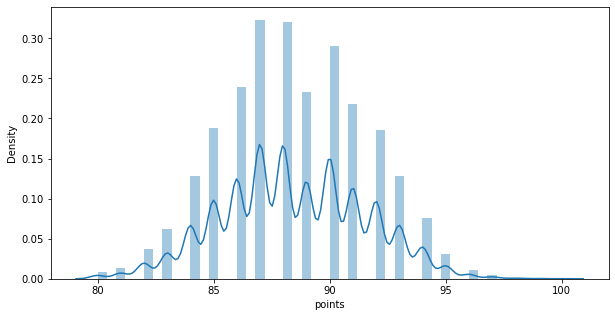

Skewness : 0.047
Kurtosis : -0.334


In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(train['points'])
plt.show()

print("Skewness : %.3f"%train['points'].skew())
print("Kurtosis : %.3f"%train['points'].kurtosis())

* points 변수의 displot과 왜도, 첨도 모두 정상적 범주의 분포를 보임을 확인할 수 있다.
* points 변수의 distplot에서 확인할 수 있는 또 다른 점은, points 변수가 연속형 자료이긴 하지만 이산적인 분포를 보이고 있다는 점이다. 즉 소수점 자리가 존재하거나 80~100점 사이 모든 점수에 대해 점수가 존재하는게 아니라 몇몇의 정수 점수만 사용되고 있으며 이는 다른 변수와 평점 간 상관성을 살펴볼 때 points 변수에 대한 boxplot을 그려볼 여지가 존재함을 의미한다

## 2. EDA

### 2.1 price와 points 변수의 관계성

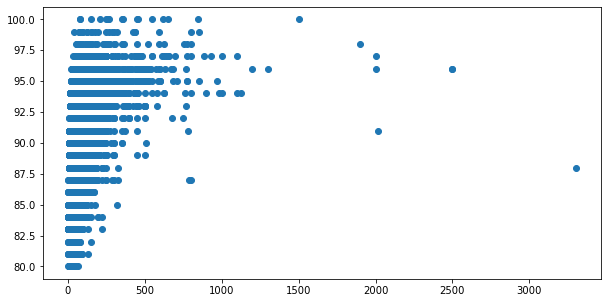

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(train['price'], train['points'])
plt.show()

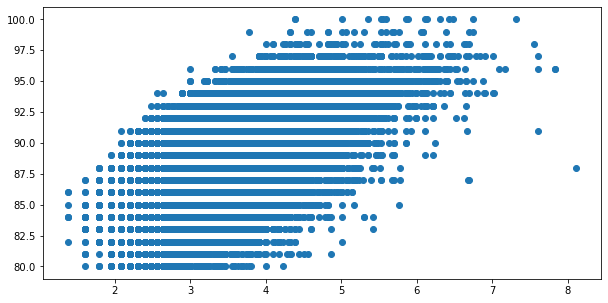

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(np.log(train['price']), train['points'])
plt.show()

* price 변수에 로그 변환을 진행한 후에 이를 points 변수와의 산점도로 표시해보면 훨씬 강한 양의 상관관계가 관찰됨을 확인할 수 있다

### 2.2 description의 길이와 points 간의 상관성

In [ ]:
#전체 데이터 중 같은 taster가 같은 description을 내린 비율
print(train.duplicated(subset=['description', 'taster_name'], keep=False).sum()/train.shape[0]*100)

0.04099578768281559


In [ ]:
#taster와 description이 같은 데이터에 대해, 평점도 같은 비율
subset=train[train.duplicated(subset=['description', 'taster_name'], keep=False)]
subset.groupby(['taster_name', 'description'])['points'].nunique().sum()/train.shape[0]*100

0.03279663014625247

* 두 가지 자료의 비율을 고려할 때, taster가 해당 와인에 남기는 description은 각 와인에 대한 고유적 특성이 충분히 반영되었다고 판단할 수 있다. 이에 descrition을 points와 연관지어 생각해보기 위해 좋은 와인에는 더 긴 리뷰를 남겼을 것이라 가정하고 EDA를 진행

In [ ]:
train['length'] = train['description'].apply(lambda x : len(str(x).split(" "))) #description 길이 추가
train = pd.merge(train, train.groupby('taster_name')['length'].mean(), how='left', on='taster_name') #train 데이터에 리뷰어 별 평균 길이 추가

train.rename(columns={'length_x':'length', 'length_y':'length_mean'}, inplace=True ) #병합 과정에서 생긴 열 이름 수정
train['length_ratio'] = train['length']/train['length_mean']


train['length_ratio'].describe()

count    77447.000000
mean         1.000000
std          0.254319
min          0.073093
25%          0.825597
50%          0.976644
75%          1.147569
max          2.933435
Name: length_ratio, dtype: float64

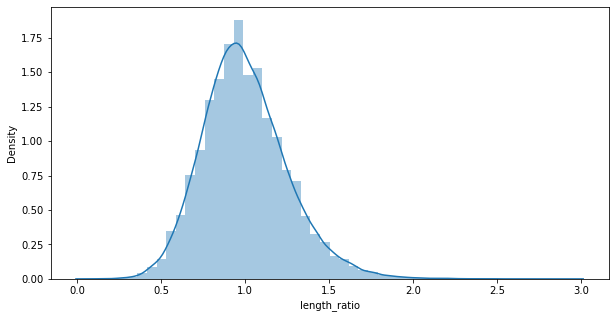

Skewness : 0.575
Kurtosis : 1.022


In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(train['length_ratio'])
plt.show()

print("Skewness : %.3f"%train['length_ratio'].skew())
print("Kurtosis : %.3f"%train['length_ratio'].kurtosis())

* 각 행에 남겨진 description의 길이를 새로운 칼럼으로 추가해줬다. 
* '좋은 와인에는 상대적으로 긴 리뷰를 남길것이다'를 가설로 채택했지만, taster마다 description의 길이에 대한 경향성이 다를 것이므로 각 taster 당 평균 리뷰 길이를 계산한 후 각 행의 descrition에 대해 나누어줬다. 
* 그렇게 계산된 length_ratio는 최솟값 0.07부터 2.93의 최댓값을 가지며 distplot과 왜도 첨도 모두 정상적 범주 내에 존재한다.

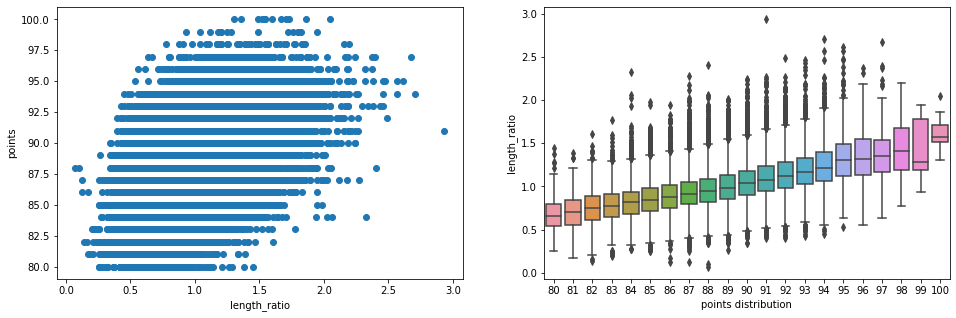

In [ ]:
fig, axes = plt.subplots(figsize=(16,5), ncols=2)
axes[0].scatter(train['length_ratio'], train['points'])
axes[0].set_xlabel("length_ratio")
axes[0].set_ylabel("points")
sns.boxplot(train['points'], train['length_ratio'], ax=axes[1])
axes[1].set_xlabel("points distribution")
axes[1].set_ylabel("length_ratio")
plt.show()

* 리뷰를 남긴 리뷰어의 평균 리뷰 길이 대비 해당 와인의 리뷰 길이와 평점간 관계를 확인해보기 위해 length_ratio를 x축, points를 y축으로 하는 산점도와 points를 x축, length_ratio를 y축으로 하는 boxplot을 그려보았다.
* 좌측 산점도에서는 약간의 양의 상관성이 있는 것처럼 보이지만 유의미한 차이를 확인하기가 힘들다
* 하지만 우측의 boxplot을 살펴보면 평점이 높아질수록 length_ratio의 중간값이 점점 상승하고 있는 것을 확인할 수 있으며 각 평점 별 quantile 역시 동시에 상승하고 있는 것을 확인할 수 있다. 
* 즉, 높은 평점이 매겨진 와인은 상대적으로 긴 리뷰 글자수 비율을 보인다는 점을 확인할 수 있다.

In [ ]:
train[['points', 'length_ratio']].corr() #상관관계 역시 약 0.5 정도의 값을 보이고 있다. 

,points,length_ratio
points,1.000000,0.489781
length_ratio,0.489781,1.000000


### 2.3 taster_name 별 평점 분포

In [ ]:
train.taster_name.value_counts()

#총 19명의 taster가 존재. 22, 6개를 기록한 두 명의 리뷰어를 제외하면 대부분 100건 이상을 진행

Roger Voss            19290
Michael Schachner     11335
Kerin O’Keefe          7960
Paul Gregutt           7236
Virginie Boone         7053
Matt Kettmann          4702
Joe Czerwinski         3864
Sean P. Sullivan       3637
Anna Lee C. Iijima     3312
Jim Gordon             3033
Anne Krebiehl MW       2680
Lauren Buzzeo          1351
Susan Kostrzewa         817
Mike DeSimone           383
Jeff Jenssen            362
Alexander Peartree      299
Carrie Dykes            105
Fiona Adams              22
Christina Pickard         6
Name: taster_name, dtype: int64

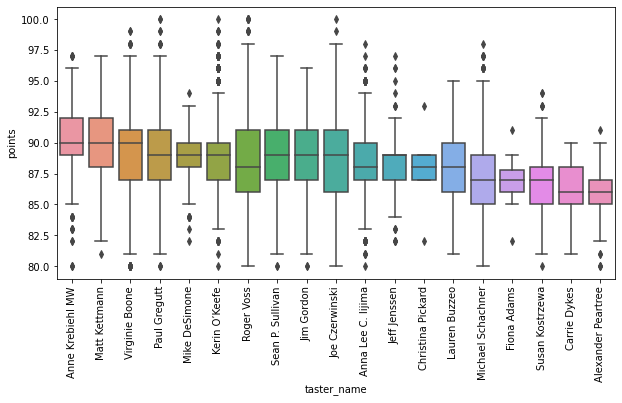

In [ ]:
index = train.groupby('taster_name').mean()['points'].sort_values(ascending=False).index

plt.figure(figsize=(10,5))
sns.boxplot(train.taster_name, train.points, order=index)
plt.xticks(rotation=90)
plt.show()

* quantile 및 이상치를 고려했을 때 어느 정도의 변동성은 존재하지만 리뷰어별로 median 값이 유의미한 경향성을 보이고 있음을 확인할 수 있다. 

### 2. 4country와 평점 분포

In [ ]:
country=pd.DataFrame(train.value_counts('country'), columns = ['count'])
country['ratio'] = country['count']/country.values.sum()*100

country[:20]

,count,ratio
country,,
US,40984,42.024958
France,16642,17.064692
Italy,14604,14.974929
Spain,4890,5.014202
Portugal,4323,4.432800
Chile,3401,3.487382
Argentina,2875,2.948023
Austria,2447,2.509152
Australia,1777,1.822134


* 설명 : 소수 국가가 많은 비율을 차지한다, 이는 province 피쳐의 존재가 필요할 수 있다는 반증 

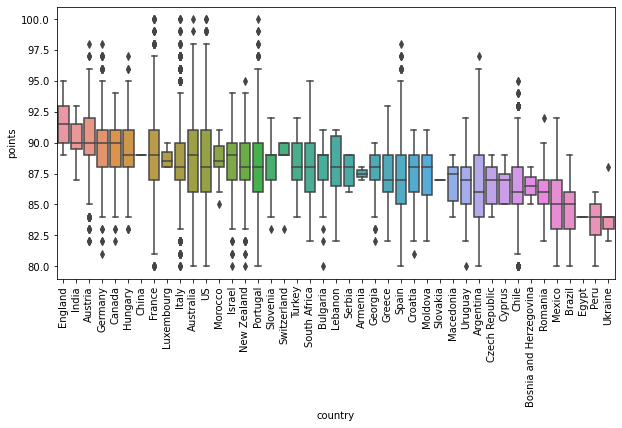

In [ ]:
index = train.groupby('country').mean()['points'].sort_values(ascending=False).index

plt.figure(figsize=(10,5))
sns.boxplot(train.country, train.points, order=index)
plt.xticks(rotation=90)
plt.show()

* country와 평점 간 boxplot 역시 median 값이 유의미한 경향성을 띄고 있음을 확인할 수 있음

## variety 분포

In [ ]:
train['variety'].value_counts()#variety 변수는 총 676개의 column, 원핫인코딩 하기에 과하게 많지는 않은 칼럼수

Pinot Noir                  10036
Chardonnay                   8825
Cabernet Sauvignon           7139
Red Blend                    6685
Bordeaux-style Red Blend     5222
                            ...  
Chardonnay-Riesling             1
Biancale                        1
Thrapsathiri                    1
Aidani                          1
Gragnano                        1
Name: variety, Length: 676, dtype: int64

In [ ]:
min_index = train['variety'].value_counts()[train['variety'].value_counts().values > 100].index

In [ ]:
top_list = train[train['variety'].isin(min_index)].groupby("variety").mean()['points'].sort_values(ascending=False)[:10]
bottom_list = train[train['variety'].isin(min_index)].groupby("variety").mean()['points'].sort_values(ascending=True)[:10]

In [ ]:
top_list

variety
Sangiovese Grosso    90.566901
Nebbiolo             90.323460
Blaufränkisch        90.120000
Grüner Veltliner     90.047521
Port                 89.857700
Tinta de Toro        89.718750
Champagne Blend      89.661366
Riesling             89.447804
Pinot Noir           89.418095
Syrah                89.318211
Name: points, dtype: float64

In [ ]:
bottom_list

variety
Torrontés           85.494845
Garnacha            85.747863
Moscato             86.140741
Pinot Grigio        86.224592
Verdejo             86.336493
Prosecco            86.402174
Carmenère           86.590164
Rosé                86.790440
Montepulciano       86.850299
Portuguese White    86.928324
Name: points, dtype: float64

In [ ]:
province=pd.DataFrame(train.value_counts('province'), columns = ['count'])
province['ratio'] = province['count']/province.values.sum()*100

province[:20]

,count,ratio
province,,
California,27287,27.980066
Washington,6487,6.651764
Bordeaux,4525,4.639931
Tuscany,4380,4.491248
Oregon,4028,4.130308
Burgundy,3040,3.117213
Northern Spain,2825,2.896753
Piedmont,2814,2.885473
Mendoza Province,2475,2.537863


### province와 평점의 관계성

In [ ]:
#최소 와인 생산 갯수가 100개 이상인 province에 대해 분석
min_index_province = train['province'].value_counts()[train['province'].value_counts().values > 100].index

top_list = train[train['province'].isin(min_index_province)].groupby("province").mean()['points'].sort_values(ascending=False)[:20]
#최소 와인 생산 갯수가 100개 이상인 province 중 평점 상위 20개 지역
bottom_list = train[train['province'].isin(min_index_province)].groupby("province").mean()['points'].sort_values(ascending=True)[:20]
#최소 와인 생산 갯수가 100개 이상인 province 중 평점 하위 20개 지역


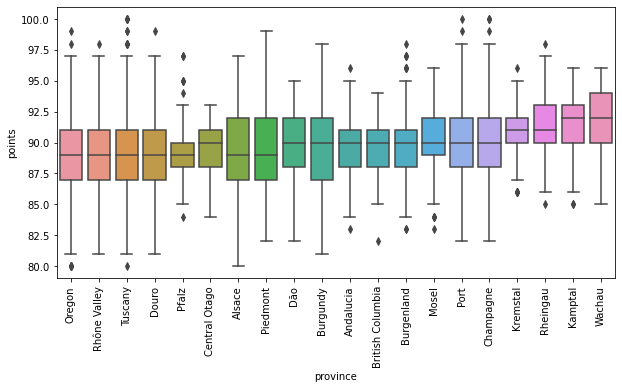

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(train[train['province'].isin(top_list.index)]['province'], train[train['province'].isin(top_list.index)]['points'], 
           order = top_list.sort_values(ascending=True).index)
plt.xticks(rotation=90)
plt.show()

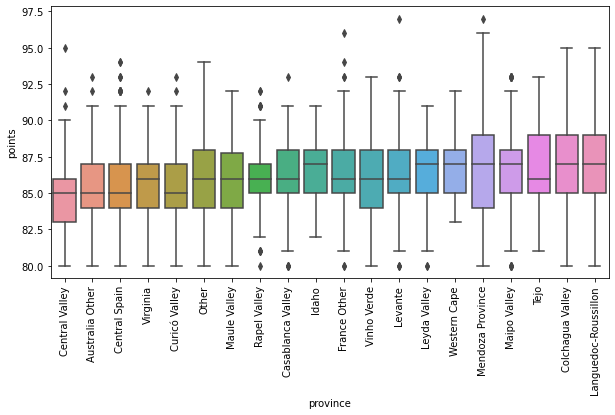

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(train[train['province'].isin(bottom_list.index)]['province'], train[train['province'].isin(bottom_list.index)]['points'], 
           order = bottom_list.sort_values(ascending=True).index)
plt.xticks(rotation=90)
plt.show()

* 평균 평점 상, 하위 20개 province에 대해 각각 평점의 boxplot을 plotting. x축의 province 나열 순서는 평균 평점 순이지만 상,하위 그래프 모두에서 province 별 유의미한 차이는 발견되지 않음
* 하지만 앞서 country 열에서 보았듯이 소수의 나라가 차지하는 비중이 매우 크다는 점에서 province 칼럼이 모델 학습이 충분히 도움이 될 수 있을 것이라 예상.